# 07. Error Analysis (Residual Analysis)

This notebook provides deep error analysis to understand **where and when models fail**.

## Analysis Categories:
1. **Time-of-day Error**: Rush hour (morning/evening) vs. off-peak
2. **Route-level Error**: Busy routes vs. less busy routes
3. **Weather-based Error**: Rain, snow, clear weather impact
4. **Error Distribution**: Overall error patterns and outliers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import utils

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Load Split Data using shared function
df_train, df_valid, df_test, df_process, split_info = utils.load_split_data_with_combined()

if df_process is None:
    raise RuntimeError("Data not found. Please run 02_process_data.ipynb first.")

## Data Preparation

Create sequences and prepare for error analysis.

In [ ]:
# Create Sequences using shared function
n_past_trips = 5
data = utils.prepare_model_data(df_train, df_test, df_process, n_past_trips=n_past_trips, include_train_sequences=False)

# Extract variables for error analysis
X_delays_test = data['X_delays_test']
y_test = data['y_test']
meta_test = data['meta_test']
n_stops = data['n_stops']

print(f"\nTest set size: {len(y_test)}")

## Generate Baseline Predictions

Use the Mean of Past N Trips as baseline for error analysis.

In [4]:
# Baseline prediction: Mean of past N trips
y_pred_baseline = X_delays_test.mean(axis=1)

# Calculate errors
errors = y_test - y_pred_baseline  # Residuals
abs_errors = np.abs(errors)

print(f"Overall MAE: {abs_errors.mean():.2f} seconds")
print(f"Overall RMSE: {np.sqrt((errors**2).mean()):.2f} seconds")
print(f"Overall R2: {r2_score(y_test.flatten(), y_pred_baseline.flatten()):.4f}")

Overall MAE: 50.83 seconds
Overall RMSE: 130.85 seconds
Overall R2: 0.2929


## Create Error Analysis DataFrame

Merge prediction errors with metadata for detailed analysis.

In [5]:
# Create error analysis DataFrame
error_df = pd.DataFrame({
    'trip_key': meta_test,
    'mae': abs_errors.mean(axis=1),
    'rmse': np.sqrt((errors**2).mean(axis=1)),
    'max_error': abs_errors.max(axis=1),
    'mean_actual': y_test.mean(axis=1),
    'mean_pred': y_pred_baseline.mean(axis=1)
})

# Extract features from trip_key (format: start_date_route_id_direction_id_trip_id)
error_df['start_date'] = error_df['trip_key'].str.split('_').str[0]
error_df['route_id'] = error_df['trip_key'].str.split('_').str[1].astype(int)
error_df['direction_id'] = error_df['trip_key'].str.split('_').str[2].astype(int)

# Merge with original features
trip_features = df_test.groupby('trip_key').agg({
    'hour': 'first',
    'is_rush_hour': 'first',
    'is_weekend': 'first',
    'day_of_week': 'first',
    'has_detour': 'max',
    'has_police_alert': 'max',
    'region_id': 'first'
}).reset_index()

error_df = error_df.merge(trip_features, on='trip_key', how='left')

print(f"Error DataFrame shape: {error_df.shape}")
error_df.head()

Error DataFrame shape: (79744, 16)


,trip_key,mae,rmse,max_error,mean_actual,mean_pred,start_date,route_id,direction_id,hour,is_rush_hour,is_weekend,day_of_week,has_detour,has_police_alert,region_id
0,20251221_10232_0_14706482,19.368539,44.284824,157.0,39.000000,41.838202,20251221,10232,0,22,0,1,6,0,0,west_vancouver
1,20251221_10232_0_14706483,16.620225,35.856744,130.2,45.033708,30.894382,20251221,10232,0,23,0,1,6,0,0,west_vancouver
2,20251221_10232_0_14706484,24.566292,55.331849,191.8,52.640449,33.229213,20251221,10232,0,0,0,1,6,0,0,west_vancouver
3,20251221_10232_0_14706485,27.253933,67.975316,396.0,60.730337,35.035955,20251221,10232,0,1,0,1,6,0,0,west_vancouver
4,20251221_10232_0_14706487,13.083146,43.481583,240.2,36.730337,43.206742,20251221,10232,0,2,0,1,6,0,0,west_vancouver


## 1. Time-of-Day Error Analysis

How does prediction accuracy vary by hour and rush hour status?

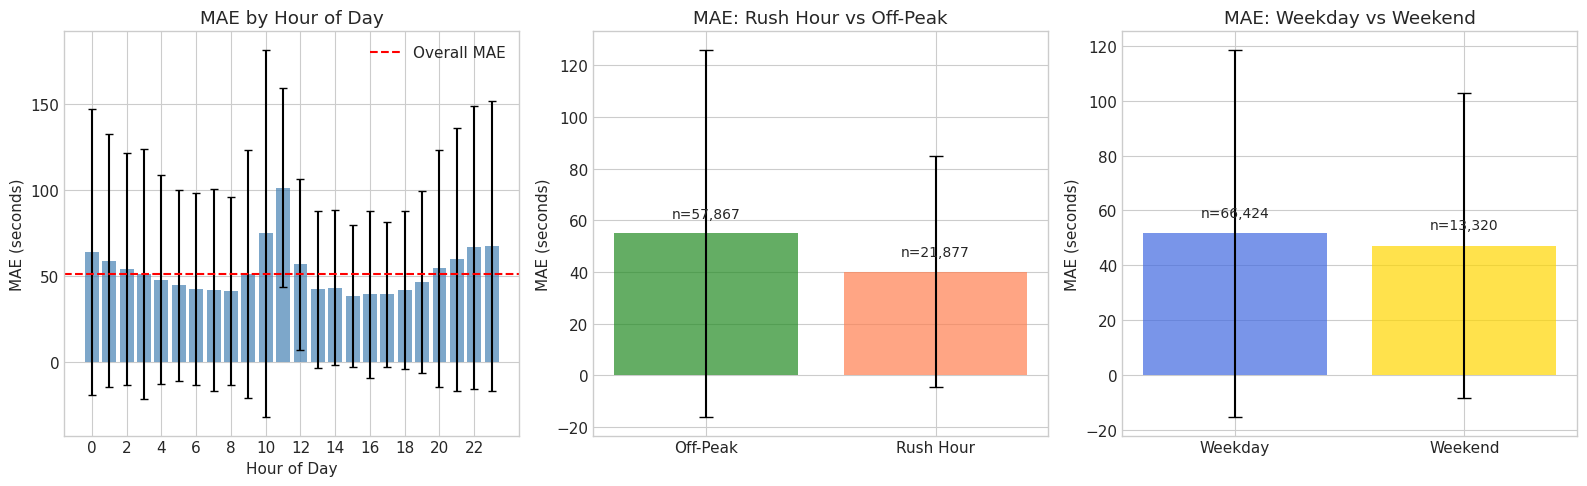


Time-based Error Summary:
Rush Hour MAE: 40.13s
Off-Peak MAE: 54.87s
Weekend MAE: 47.08s
Weekday MAE: 51.58s


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Hourly MAE
hourly_mae = error_df.groupby('hour')['mae'].agg(['mean', 'std']).reset_index()
axes[0].bar(hourly_mae['hour'], hourly_mae['mean'], yerr=hourly_mae['std'], 
            alpha=0.7, capsize=3, color='steelblue')
axes[0].axhline(y=error_df['mae'].mean(), color='red', linestyle='--', label='Overall MAE')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('MAE (seconds)')
axes[0].set_title('MAE by Hour of Day')
axes[0].legend()
axes[0].set_xticks(range(0, 24, 2))

# Rush Hour vs Non-Rush Hour
rush_comparison = error_df.groupby('is_rush_hour')['mae'].agg(['mean', 'std', 'count']).reset_index()
rush_comparison['label'] = rush_comparison['is_rush_hour'].map({0: 'Off-Peak', 1: 'Rush Hour'})
bars = axes[1].bar(rush_comparison['label'], rush_comparison['mean'], 
                   yerr=rush_comparison['std'], alpha=0.7, capsize=5, 
                   color=['forestgreen', 'coral'])
axes[1].set_ylabel('MAE (seconds)')
axes[1].set_title('MAE: Rush Hour vs Off-Peak')

# Add sample counts
for bar, count in zip(bars, rush_comparison['count']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 f'n={count:,}', ha='center', va='bottom', fontsize=10)

# Weekend vs Weekday
weekend_comparison = error_df.groupby('is_weekend')['mae'].agg(['mean', 'std', 'count']).reset_index()
weekend_comparison['label'] = weekend_comparison['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})
bars = axes[2].bar(weekend_comparison['label'], weekend_comparison['mean'], 
                   yerr=weekend_comparison['std'], alpha=0.7, capsize=5,
                   color=['royalblue', 'gold'])
axes[2].set_ylabel('MAE (seconds)')
axes[2].set_title('MAE: Weekday vs Weekend')

for bar, count in zip(bars, weekend_comparison['count']):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 f'n={count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('data/processed_data/error_analysis_time.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTime-based Error Summary:")
print(f"Rush Hour MAE: {error_df[error_df['is_rush_hour']==1]['mae'].mean():.2f}s")
print(f"Off-Peak MAE: {error_df[error_df['is_rush_hour']==0]['mae'].mean():.2f}s")
print(f"Weekend MAE: {error_df[error_df['is_weekend']==1]['mae'].mean():.2f}s")
print(f"Weekday MAE: {error_df[error_df['is_weekend']==0]['mae'].mean():.2f}s")

## 2. Route-Level Error Analysis

Which routes have the highest/lowest prediction errors?

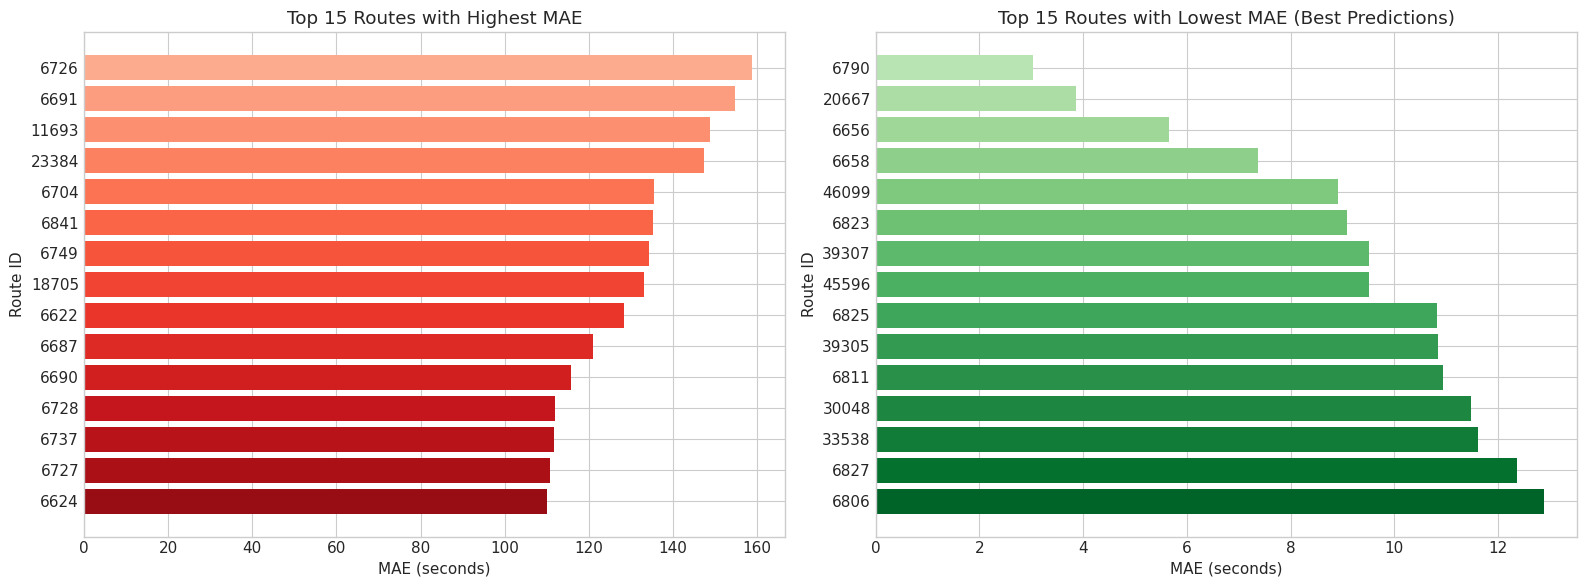


Route Error Summary (routes with >= 50 samples):
Total routes analyzed: 195
Best performing route: 6790.0 (MAE: 3.03s)
Worst performing route: 6726.0 (MAE: 158.73s)


In [7]:
# Calculate route-level statistics
route_stats = error_df.groupby('route_id').agg({
    'mae': ['mean', 'std', 'count'],
    'mean_actual': 'mean'
}).reset_index()
route_stats.columns = ['route_id', 'mae_mean', 'mae_std', 'sample_count', 'avg_delay']

# Filter routes with sufficient samples
min_samples = 50
route_stats_filtered = route_stats[route_stats['sample_count'] >= min_samples].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 routes by MAE
top_routes = route_stats_filtered.nlargest(15, 'mae_mean')
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(top_routes)))
axes[0].barh(range(len(top_routes)), top_routes['mae_mean'], color=colors)
axes[0].set_yticks(range(len(top_routes)))
axes[0].set_yticklabels(top_routes['route_id'].astype(str))
axes[0].set_xlabel('MAE (seconds)')
axes[0].set_ylabel('Route ID')
axes[0].set_title('Top 15 Routes with Highest MAE')
axes[0].invert_yaxis()

# Bottom 15 routes by MAE (best performing)
bottom_routes = route_stats_filtered.nsmallest(15, 'mae_mean')
colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(bottom_routes)))
axes[1].barh(range(len(bottom_routes)), bottom_routes['mae_mean'], color=colors)
axes[1].set_yticks(range(len(bottom_routes)))
axes[1].set_yticklabels(bottom_routes['route_id'].astype(str))
axes[1].set_xlabel('MAE (seconds)')
axes[1].set_ylabel('Route ID')
axes[1].set_title('Top 15 Routes with Lowest MAE (Best Predictions)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('data/processed_data/error_analysis_route.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nRoute Error Summary (routes with >= {min_samples} samples):")
print(f"Total routes analyzed: {len(route_stats_filtered)}")
print(f"Best performing route: {bottom_routes.iloc[0]['route_id']} (MAE: {bottom_routes.iloc[0]['mae_mean']:.2f}s)")
print(f"Worst performing route: {top_routes.iloc[0]['route_id']} (MAE: {top_routes.iloc[0]['mae_mean']:.2f}s)")

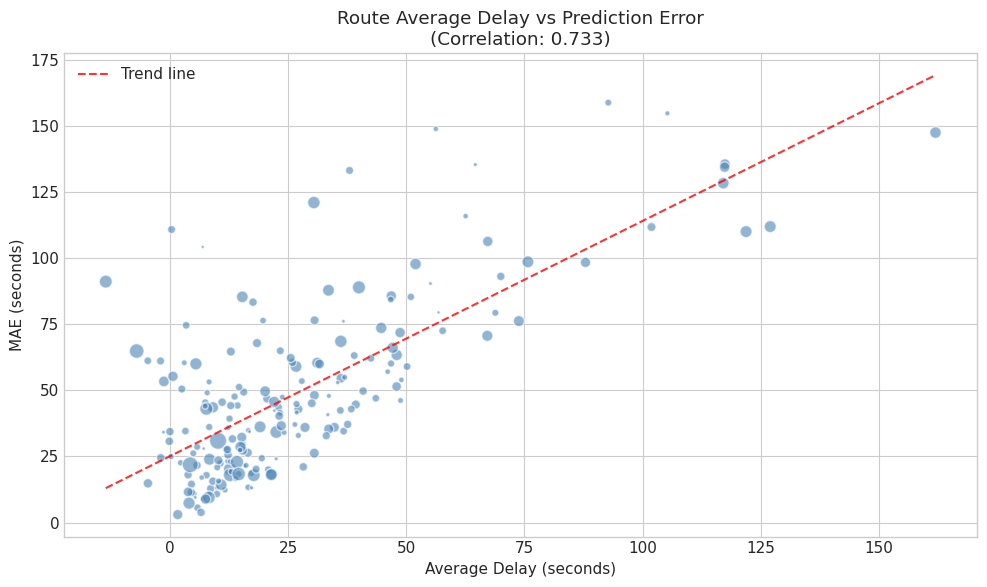

Correlation between average delay and MAE: 0.733


In [8]:
# Correlation between average delay and MAE
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(route_stats_filtered['avg_delay'], 
                     route_stats_filtered['mae_mean'],
                     s=route_stats_filtered['sample_count'] / 10,
                     alpha=0.6, c='steelblue', edgecolors='white')

# Add correlation line
z = np.polyfit(route_stats_filtered['avg_delay'], route_stats_filtered['mae_mean'], 1)
p = np.poly1d(z)
ax.plot(route_stats_filtered['avg_delay'].sort_values(), 
        p(route_stats_filtered['avg_delay'].sort_values()), 
        'r--', alpha=0.8, label='Trend line')

correlation = route_stats_filtered['avg_delay'].corr(route_stats_filtered['mae_mean'])
ax.set_xlabel('Average Delay (seconds)')
ax.set_ylabel('MAE (seconds)')
ax.set_title(f'Route Average Delay vs Prediction Error\n(Correlation: {correlation:.3f})')
ax.legend()

plt.tight_layout()
plt.savefig('data/processed_data/error_analysis_delay_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Correlation between average delay and MAE: {correlation:.3f}")

## 3. Region-Level Error Analysis

How does prediction accuracy vary by geographic region?

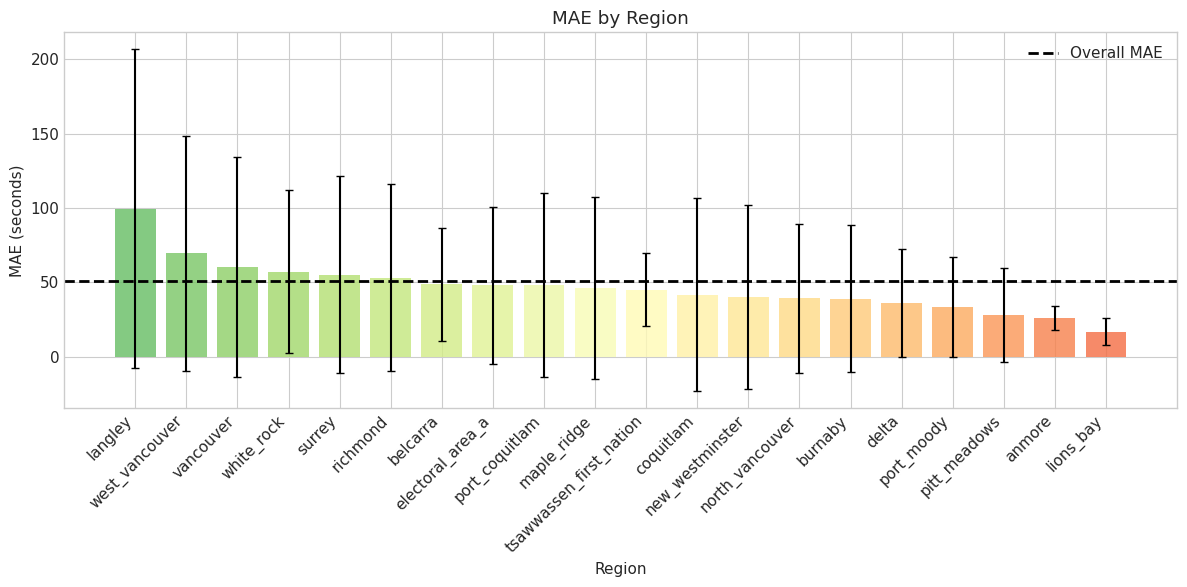


Region Error Summary:
              region_id  mae_mean    mae_std  sample_count
                langley 99.458065 107.293631          1579
         west_vancouver 69.506955  79.052858          1873
              vancouver 60.403602  74.005654         19282
             white_rock 57.147752  54.696089          1127
                 surrey 55.133554  66.394557         13353
               richmond 53.090759  62.787836          5460
               belcarra 48.671568  38.138230           105
       electoral_area_a 48.015831  52.740248          3977
         port_coquitlam 47.955517  62.038924          1433
            maple_ridge 46.220618  61.126348          1835
tsawwassen_first_nation 45.098876  24.505196             3
              coquitlam 41.710965  65.056793          4817
        new_westminster 39.919280  61.936919          5321
        north_vancouver 39.132669  50.036642          5971
                burnaby 38.954111  49.622736         10049
                  delta 36.163067

In [9]:
# Region-level analysis
region_stats = error_df.groupby('region_id').agg({
    'mae': ['mean', 'std', 'count']
}).reset_index()
region_stats.columns = ['region_id', 'mae_mean', 'mae_std', 'sample_count']
region_stats = region_stats.sort_values('mae_mean', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(region_stats)))
bars = ax.bar(range(len(region_stats)), region_stats['mae_mean'], 
              yerr=region_stats['mae_std'], capsize=3, color=colors, alpha=0.8)
ax.axhline(y=error_df['mae'].mean(), color='black', linestyle='--', 
           linewidth=2, label='Overall MAE')

ax.set_xticks(range(len(region_stats)))
ax.set_xticklabels(region_stats['region_id'], rotation=45, ha='right')
ax.set_xlabel('Region')
ax.set_ylabel('MAE (seconds)')
ax.set_title('MAE by Region')
ax.legend()

plt.tight_layout()
plt.savefig('data/processed_data/error_analysis_region.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nRegion Error Summary:")
print(region_stats.to_string(index=False))

## 4. Alert/Special Conditions Analysis

Impact of detours and police alerts on prediction accuracy.

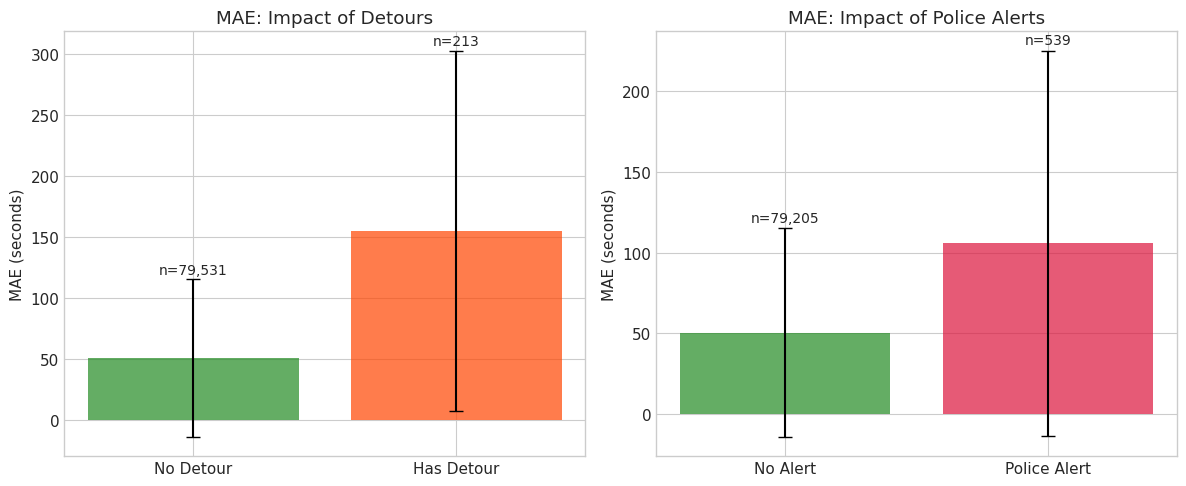


Alert Impact Summary:
No Detour MAE: 50.55s
Has Detour MAE: 154.83s
No Police Alert MAE: 50.45s
Has Police Alert MAE: 105.68s


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Detour impact
detour_stats = error_df.groupby('has_detour')['mae'].agg(['mean', 'std', 'count']).reset_index()
detour_stats['label'] = detour_stats['has_detour'].map({0: 'No Detour', 1: 'Has Detour'})

bars = axes[0].bar(detour_stats['label'], detour_stats['mean'], 
                   yerr=detour_stats['std'], alpha=0.7, capsize=5,
                   color=['forestgreen', 'orangered'])
axes[0].set_ylabel('MAE (seconds)')
axes[0].set_title('MAE: Impact of Detours')

for bar, row in zip(bars, detour_stats.itertuples()):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + row.std + 2, 
                 f'n={row.count:,}', ha='center', va='bottom', fontsize=10)

# Police alert impact
police_stats = error_df.groupby('has_police_alert')['mae'].agg(['mean', 'std', 'count']).reset_index()
police_stats['label'] = police_stats['has_police_alert'].map({0: 'No Alert', 1: 'Police Alert'})

bars = axes[1].bar(police_stats['label'], police_stats['mean'], 
                   yerr=police_stats['std'], alpha=0.7, capsize=5,
                   color=['forestgreen', 'crimson'])
axes[1].set_ylabel('MAE (seconds)')
axes[1].set_title('MAE: Impact of Police Alerts')

for bar, row in zip(bars, police_stats.itertuples()):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + row.std + 2, 
                 f'n={row.count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('data/processed_data/error_analysis_alerts.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAlert Impact Summary:")
print(f"No Detour MAE: {error_df[error_df['has_detour']==0]['mae'].mean():.2f}s")
print(f"Has Detour MAE: {error_df[error_df['has_detour']==1]['mae'].mean():.2f}s")
print(f"No Police Alert MAE: {error_df[error_df['has_police_alert']==0]['mae'].mean():.2f}s")
print(f"Has Police Alert MAE: {error_df[error_df['has_police_alert']==1]['mae'].mean():.2f}s")

## 5. Error Distribution Analysis

Overall distribution of prediction errors and outlier identification.

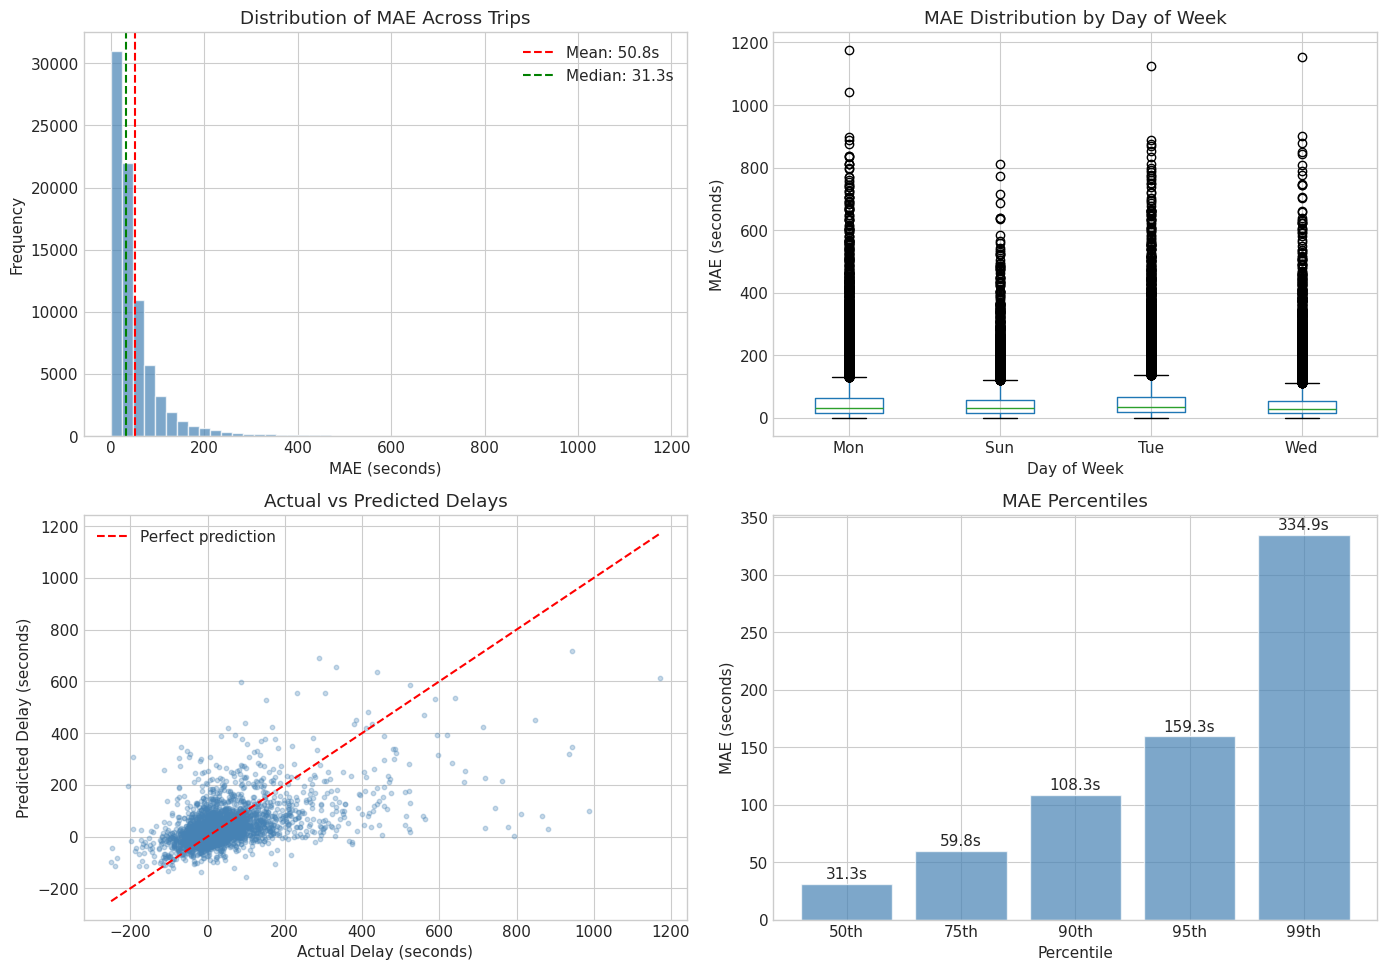


Error Distribution Statistics:
Mean MAE: 50.83s
Median MAE: 31.29s
Std MAE: 65.27s
Min MAE: 0.13s
Max MAE: 1175.24s

Percentiles:
  50th: 31.29s
  75th: 59.76s
  90th: 108.25s
  95th: 159.26s
  99th: 334.87s


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Error histogram
axes[0, 0].hist(error_df['mae'], bins=50, edgecolor='white', alpha=0.7, color='steelblue')
axes[0, 0].axvline(x=error_df['mae'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {error_df["mae"].mean():.1f}s')
axes[0, 0].axvline(x=error_df['mae'].median(), color='green', linestyle='--', 
                   label=f'Median: {error_df["mae"].median():.1f}s')
axes[0, 0].set_xlabel('MAE (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of MAE Across Trips')
axes[0, 0].legend()

# Box plot by day of week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
error_df['day_name'] = error_df['day_of_week'].map(lambda x: day_names[int(x)] if pd.notna(x) else 'Unknown')
error_df.boxplot(column='mae', by='day_name', ax=axes[0, 1])
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('MAE (seconds)')
axes[0, 1].set_title('MAE Distribution by Day of Week')
plt.suptitle('')  # Remove automatic title

# Residual plot (actual vs predicted)
sample_size = min(5000, len(error_df))
sample_df = error_df.sample(sample_size, random_state=42)
axes[1, 0].scatter(sample_df['mean_actual'], sample_df['mean_pred'], 
                   alpha=0.3, s=10, c='steelblue')
max_val = max(sample_df['mean_actual'].max(), sample_df['mean_pred'].max())
min_val = min(sample_df['mean_actual'].min(), sample_df['mean_pred'].min())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
axes[1, 0].set_xlabel('Actual Delay (seconds)')
axes[1, 0].set_ylabel('Predicted Delay (seconds)')
axes[1, 0].set_title('Actual vs Predicted Delays')
axes[1, 0].legend()

# Error percentile
percentiles = [50, 75, 90, 95, 99]
percentile_values = [np.percentile(error_df['mae'], p) for p in percentiles]
axes[1, 1].bar([f'{p}th' for p in percentiles], percentile_values, 
               color='steelblue', alpha=0.7, edgecolor='white')
axes[1, 1].set_xlabel('Percentile')
axes[1, 1].set_ylabel('MAE (seconds)')
axes[1, 1].set_title('MAE Percentiles')

for i, (p, v) in enumerate(zip(percentiles, percentile_values)):
    axes[1, 1].text(i, v + 2, f'{v:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('data/processed_data/error_analysis_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nError Distribution Statistics:")
print(f"Mean MAE: {error_df['mae'].mean():.2f}s")
print(f"Median MAE: {error_df['mae'].median():.2f}s")
print(f"Std MAE: {error_df['mae'].std():.2f}s")
print(f"Min MAE: {error_df['mae'].min():.2f}s")
print(f"Max MAE: {error_df['mae'].max():.2f}s")
print(f"\nPercentiles:")
for p, v in zip(percentiles, percentile_values):
    print(f"  {p}th: {v:.2f}s")

## 6. Outlier Analysis

Identify and analyze trips with unusually high prediction errors.

In [12]:
# Define outliers as trips with MAE > 95th percentile
outlier_threshold = np.percentile(error_df['mae'], 95)
outliers = error_df[error_df['mae'] > outlier_threshold].copy()

print(f"Outlier threshold (95th percentile): {outlier_threshold:.2f}s")
print(f"Number of outlier trips: {len(outliers)} ({len(outliers)/len(error_df)*100:.1f}%)")

# Compare outlier characteristics
print("\nOutlier Characteristics vs Normal:")
print(f"{'Metric':<20} {'Outliers':>12} {'Normal':>12}")
print("-" * 46)

normal = error_df[error_df['mae'] <= outlier_threshold]

metrics = [
    ('Rush Hour %', 'is_rush_hour'),
    ('Weekend %', 'is_weekend'),
    ('Has Detour %', 'has_detour'),
    ('Has Police Alert %', 'has_police_alert'),
    ('Avg Hour', 'hour'),
    ('Avg Actual Delay', 'mean_actual')
]

for name, col in metrics:
    if '%' in name:
        outlier_val = f"{outliers[col].mean()*100:.1f}%"
        normal_val = f"{normal[col].mean()*100:.1f}%"
    else:
        outlier_val = f"{outliers[col].mean():.1f}"
        normal_val = f"{normal[col].mean():.1f}"
    print(f"{name:<20} {outlier_val:>12} {normal_val:>12}")

Outlier threshold (95th percentile): 159.26s
Number of outlier trips: 3988 (5.0%)

Outlier Characteristics vs Normal:
Metric                   Outliers       Normal
----------------------------------------------
Rush Hour %                 11.2%        28.3%
Weekend %                   13.5%        16.9%
Has Detour %                 2.0%         0.2%
Has Police Alert %           2.7%         0.6%
Avg Hour                     11.8         12.0
Avg Actual Delay            219.8         18.2


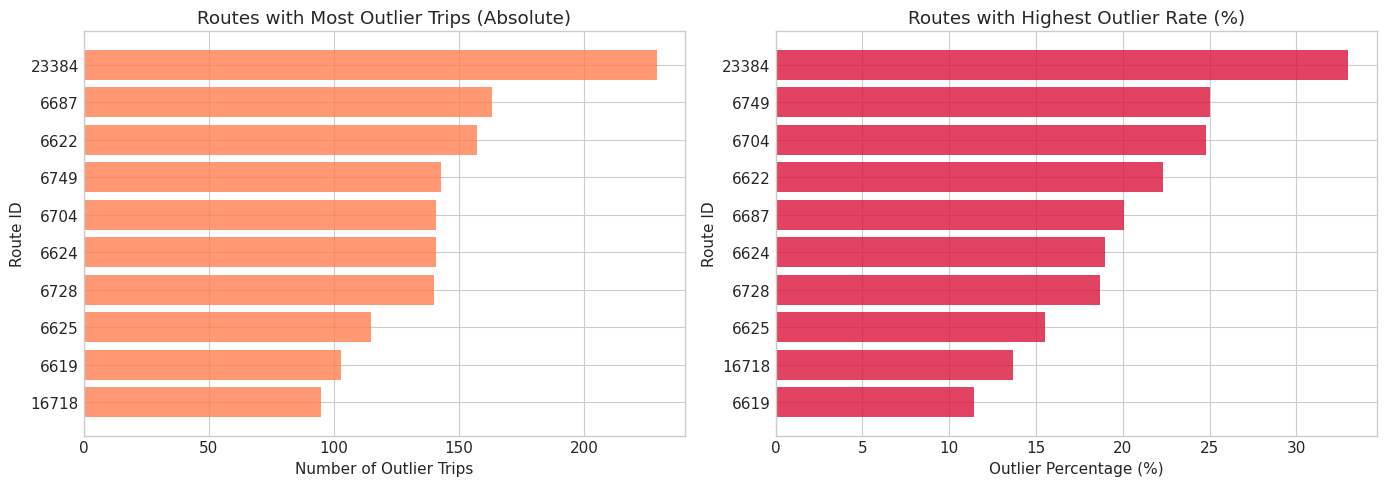

In [13]:
# Routes with most outliers
outlier_routes = outliers.groupby('route_id').size().sort_values(ascending=False).head(10)
total_by_route = error_df.groupby('route_id').size()

outlier_route_pct = (outlier_routes / total_by_route[outlier_routes.index] * 100).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute count
axes[0].barh(range(len(outlier_routes)), outlier_routes.values, color='coral', alpha=0.8)
axes[0].set_yticks(range(len(outlier_routes)))
axes[0].set_yticklabels(outlier_routes.index.astype(str))
axes[0].set_xlabel('Number of Outlier Trips')
axes[0].set_ylabel('Route ID')
axes[0].set_title('Routes with Most Outlier Trips (Absolute)')
axes[0].invert_yaxis()

# Percentage
top_pct_routes = outlier_route_pct.head(10)
axes[1].barh(range(len(top_pct_routes)), top_pct_routes.values, color='crimson', alpha=0.8)
axes[1].set_yticks(range(len(top_pct_routes)))
axes[1].set_yticklabels(top_pct_routes.index.astype(str))
axes[1].set_xlabel('Outlier Percentage (%)')
axes[1].set_ylabel('Route ID')
axes[1].set_title('Routes with Highest Outlier Rate (%)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('data/processed_data/error_analysis_outliers.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary and Recommendations

In [14]:
print("="*60)
print("ERROR ANALYSIS SUMMARY")
print("="*60)

print("\n1. OVERALL PERFORMANCE:")
print(f"   - Overall MAE: {error_df['mae'].mean():.2f}s")
print(f"   - Median MAE: {error_df['mae'].median():.2f}s")
print(f"   - 95th Percentile MAE: {np.percentile(error_df['mae'], 95):.2f}s")

print("\n2. TIME-BASED INSIGHTS:")
rush_diff = error_df[error_df['is_rush_hour']==1]['mae'].mean() - error_df[error_df['is_rush_hour']==0]['mae'].mean()
print(f"   - Rush hour vs Off-peak difference: {rush_diff:+.2f}s")
weekend_diff = error_df[error_df['is_weekend']==1]['mae'].mean() - error_df[error_df['is_weekend']==0]['mae'].mean()
print(f"   - Weekend vs Weekday difference: {weekend_diff:+.2f}s")

print("\n3. ROUTE-LEVEL INSIGHTS:")
print(f"   - Best route MAE: {route_stats_filtered['mae_mean'].min():.2f}s")
print(f"   - Worst route MAE: {route_stats_filtered['mae_mean'].max():.2f}s")
print(f"   - Route MAE std: {route_stats_filtered['mae_mean'].std():.2f}s")

print("\n4. ALERT IMPACT:")
detour_diff = error_df[error_df['has_detour']==1]['mae'].mean() - error_df[error_df['has_detour']==0]['mae'].mean()
print(f"   - Detour impact: {detour_diff:+.2f}s")
police_diff = error_df[error_df['has_police_alert']==1]['mae'].mean() - error_df[error_df['has_police_alert']==0]['mae'].mean()
print(f"   - Police alert impact: {police_diff:+.2f}s")

print("\n5. RECOMMENDATIONS:")
print("   - Focus on high-error routes for model improvement")
print("   - Consider separate models for rush hour periods")
print("   - Add weather features if available")
print("   - Investigate outlier trips for data quality issues")

print("\n" + "="*60)

ERROR ANALYSIS SUMMARY

1. OVERALL PERFORMANCE:
   - Overall MAE: 50.83s
   - Median MAE: 31.29s
   - 95th Percentile MAE: 159.26s

2. TIME-BASED INSIGHTS:
   - Rush hour vs Off-peak difference: -14.74s
   - Weekend vs Weekday difference: -4.50s

3. ROUTE-LEVEL INSIGHTS:
   - Best route MAE: 3.03s
   - Worst route MAE: 158.73s
   - Route MAE std: 33.23s

4. ALERT IMPACT:
   - Detour impact: +104.29s
   - Police alert impact: +55.23s

5. RECOMMENDATIONS:
   - Focus on high-error routes for model improvement
   - Consider separate models for rush hour periods
   - Add weather features if available
   - Investigate outlier trips for data quality issues



In [15]:
# Save error analysis results
error_df.to_csv('data/processed_data/error_analysis_results.csv', index=False)
route_stats_filtered.to_csv('data/processed_data/error_analysis_by_route.csv', index=False)
region_stats.to_csv('data/processed_data/error_analysis_by_region.csv', index=False)

print("Error analysis results saved to data/processed_data/")

Error analysis results saved to data/processed_data/
